In [7]:
%load_ext autoreload

%autoreload 2

import sys 
sys.path.insert(0, './..')
sys.path.insert(0, '.')


import pandas as pd
import random
import numpy as np
from sklearn import linear_model, mixture, cluster
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.io
from scipy.stats import zscore, sem
from scipy.optimize import minimize
from tqdm.notebook import trange, tqdm
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# own modules
from utils import load_data_patient, load_data_controls
from model import fit, nll

%run -i '../helperFiles/style_script.py'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def convert_to_labels(labels): 
    conv_table = {'w_mu': '$w_{\mu}$',
                  'w_sigma': '$w_{\sigma}$',
                  'w_rej': '$w_{rej}$',
                  'w_crej': '$w_{crej}$',
                  'w_reg': '$w_{reg}$',
                  'w_creg': '$w_{creg}$',
                  'w_up': '$w_{up}$',
                  'w_down': '$w_{down}$',
                  'w_prev': '$w_{b}$',
                  'alpha': r'$\alpha$',
                  'a_mu': '$\gamma_{\mu}$',
                  'a_sigma': '$\gamma_{\sigma}$',
                  'a_rej': '$\gamma_{rej}$',
                  'a_crej': '$\gamma_{crej}$',
                  'a_reg': '$\gamma_{reg}$',
                  'a_creg': '$\gamma_{creg}$',
                  'a_up': '$\gamma_{up}$',
                  'a_down': '$\gamma_{down}$',
                 }
    return [conv_table[label] for label in labels]

def fit_model(all_data, all_preds, opt_params):
    results_controls = []
    results_patients = []
    all_results = [results_controls, results_patients]
    
    ps_controls = []
    ps_patients = []
    all_ps = [ps_controls, ps_patients]
    
    true_ps_controls = []
    true_ps_patients = []
    all_true_ps = [true_ps_controls, true_ps_patients]
    
    for data, cluster_result, cluster_ps, cluster_true_ps, preds in zip(all_data, all_results, all_ps, all_true_ps, all_preds):
    
        for cluster in [0,1]:
            result = pd.DataFrame()
            ps = []
            true_ps = []

            for i, subject in enumerate(tqdm(data)):

                if not preds[i]==cluster:
                    continue

                subject['prev'] = subject['bet']
                for column in subject.columns:
                    if not (column in ['bet', 'd_bet', 'subj']) and subject[column].sum()!=0:
                        subject[column] = zscore(subject[column], nan_policy='omit')

                x0 = np.random.normal(0, .1, len(opt_params))
                x_fit, ll, bic, true_p, p = fit(subject, x0, opt_params)
                df = pd.DataFrame(data=[x_fit], columns=opt_params)
                df['ll'] = ll
                df['bic'] = bic
                result = result.append(df, ignore_index=True)
                ps.append(p)
                true_ps.append(true_p)
            
            cluster_ps.append(ps)
            cluster_true_ps.append(true_ps)
            cluster_result.append(result)
    
    return all_results, all_true_ps, all_ps

def chance_level_bic(all_data, groups, opt_params, all_preds):
    print('Chance Levels')
    for data, group, preds in zip(all_data, groups, all_preds):
            
        for cluster in [0,1]:
            rel_data_len = 0
            for i, subject in enumerate(data):
                if preds[i]==cluster:
                    rel_data_len += (~np.isnan(subject['bet'])).sum()
            llc = np.log(np.ones(rel_data_len)/11).sum()
            bic_c = len(opt_params) * np.log(rel_data_len) - 2 * llc
            print(group + ' - Cluster %d, BIC_c: %.0f' % (cluster+1, bic_c))

# Load data

In [9]:
all_preds = [np.load('../data/clusters_controls.npy'), np.load('../data/clusters_patients.npy')]
all_data = [load_data_controls('all'), load_data_patient('all')]
groups = ['Controls', 'Patients']

chance_level_bic(all_data, groups, [], all_preds)

Chance Levels
Controls - Cluster 1, BIC_c: 20142
Controls - Cluster 2, BIC_c: 21101
Patients - Cluster 1, BIC_c: 6906
Patients - Cluster 2, BIC_c: 3328


# Basic model

In [10]:
opt_params = ['w_prev',
              'w_rej',
              'w_reg',
              'w_crej',
              'w_creg',
              'w_mu',
              'w_up',
              'w_down',
]

results_basic = fit_model(all_data, all_preds, opt_params)

Results
Controls - Cluster: 1, BIC 15896
Patients - Cluster: 2, BIC 14775
Controls - Cluster: 1, BIC 5271
Patients - Cluster: 2, BIC 2552


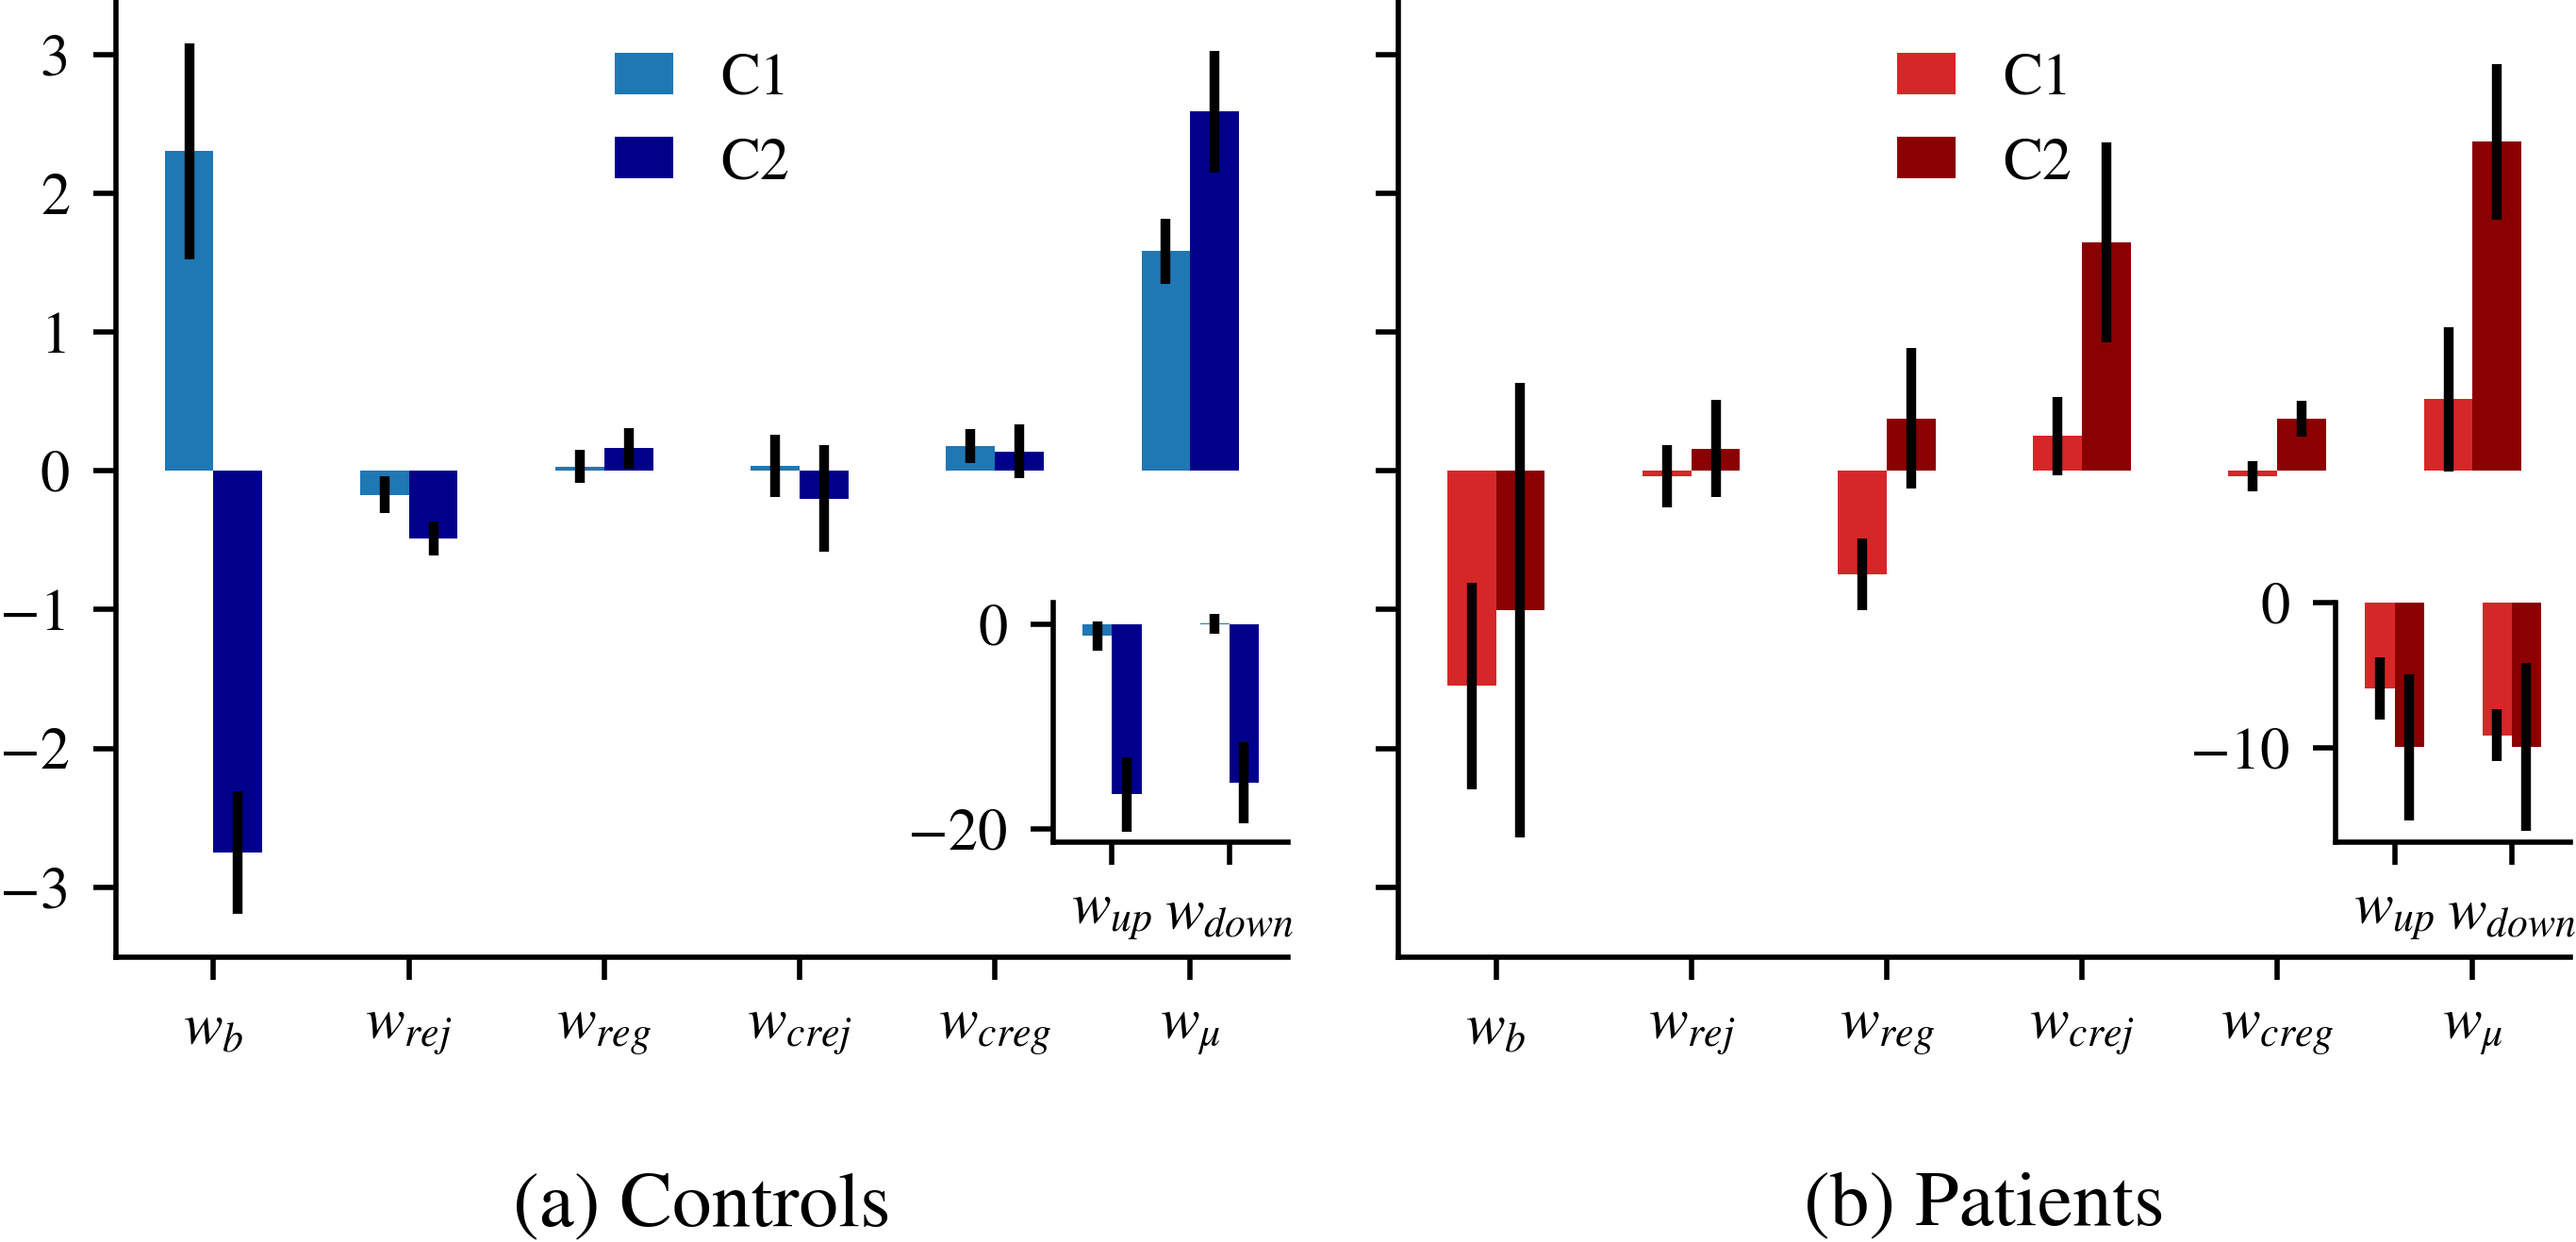

In [27]:
print('Results')
for i, result in enumerate(results_basic[0]):
    for cluster in [0,1]:
        print(groups[cluster] + ' - Cluster: %d, BIC %d' % (cluster+1, result[cluster]['bic'].sum()))

fig, ax = plt.subplots(1,2,figsize=(figwidth, 3), dpi=500, sharey=True)

for i, result in enumerate(results_basic[0]):
    results_cluster1 = result[0].drop(columns=['bic', 'll', 'w_up', 'w_down'])
    results_cluster2 = result[1].drop(columns=['bic', 'll', 'w_up', 'w_down'])
    err = [sem(results_cluster1), sem(results_cluster2)]
    
    pd.DataFrame({'C1': results_cluster1.mean(), 'C2': results_cluster2.mean()}).plot(kind='bar', ax=ax[i], color=colors[i], yerr=err).legend(loc='upper center', frameon=False, handlelength=1)
    ax[i].set_xticklabels(convert_to_labels(results_cluster1.columns), rotation=0)

    ins = ax[i].inset_axes([0.8,0.12,0.2,0.25])
    results_cluster1 = result[0][['w_up', 'w_down']]
    results_cluster2 = result[1][['w_up', 'w_down']]
    err = [sem(results_cluster1), sem(results_cluster2)]
    pd.DataFrame({'C1': results_cluster1.mean(), 'C2': results_cluster2.mean()}).plot(kind='bar', ax=ins, color=colors[i], yerr=err, legend=False)
    ins.set_xticklabels(convert_to_labels(results_cluster1.columns), rotation=0, fontsize=9)

ax[0].text(0.5, -.28, '(a) Controls', ha='center', fontsize=12,transform=ax[0].transAxes)
ax[1].text(0.5, -.28 ,'(b) Patients', ha='center', fontsize=12,transform=ax[1].transAxes)
plt.tight_layout()
plt.savefig('../figures/comp_basic.pdf')
plt.savefig('../figures/comp_basic.png')

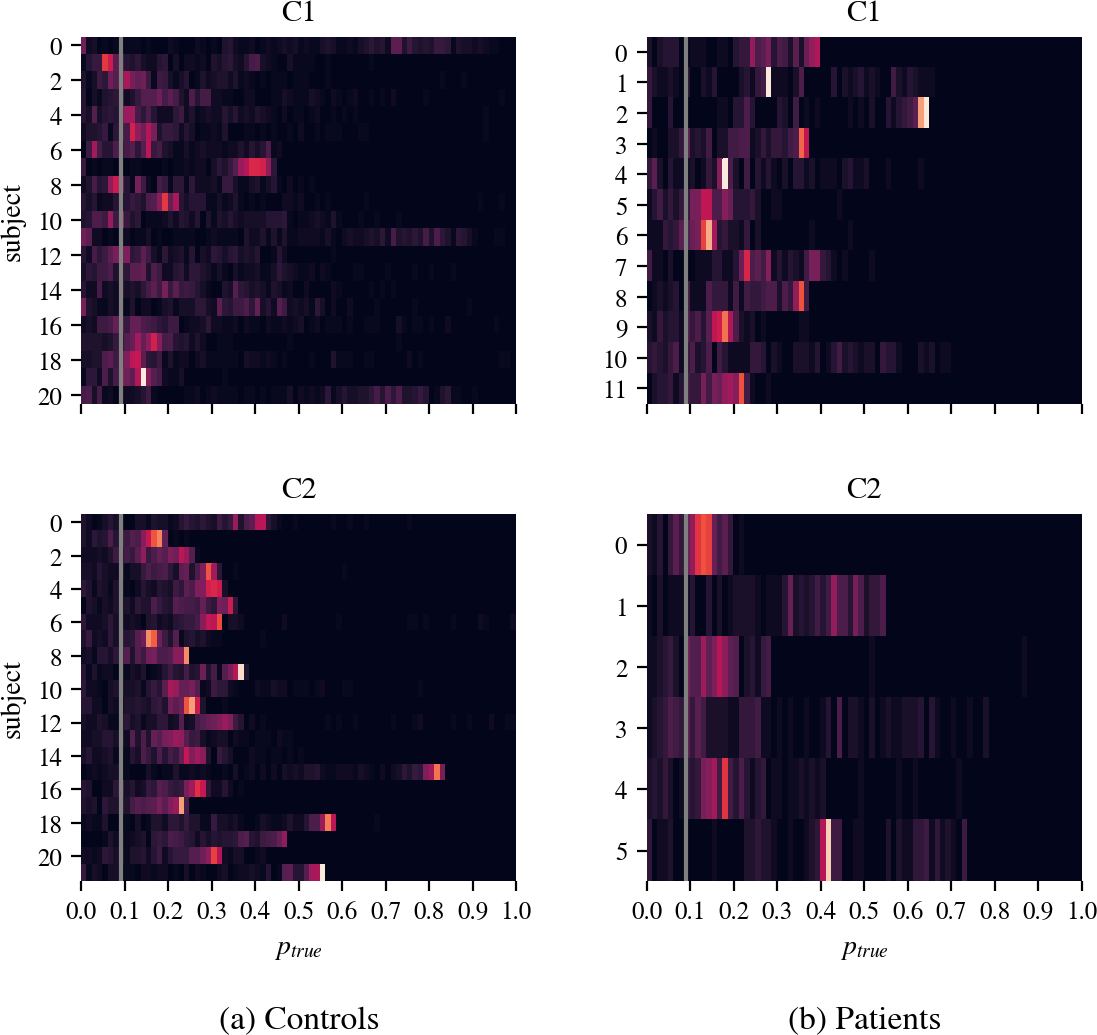

In [12]:
fig, axs = plt.subplots(2,2, figsize=(figwidth,5.5), dpi=200, sharex=True)
bins = np.linspace(0,1,81)

for j, (cluster_data, cluster_result, preds) in enumerate(zip(all_data, results_basic[1], all_preds)):
    
    for cluster in [0,1]:
        
        freqs = []
        data = np.array(cluster_data)[preds==cluster]
        
        for i, (subject, result) in enumerate(zip(data, cluster_result[cluster])):
            freq = np.histogram(result, bins=bins)[0]
            freqs.append(freq/freq.sum())

        sns.heatmap(freqs, ax=axs[cluster,j], cbar=False, vmin=0, vmax=.25, rasterized=True)
        
        axs[cluster, j].set_xticks(np.linspace(0,len(bins)-1,11))
        axs[cluster, j].set_xticklabels([np.around(x,1) for x in np.linspace(0,1,11)])
        axs[cluster, j].set_yticklabels(axs[cluster, j].get_yticklabels(), rotation=0)
        axs[cluster, 0].set_ylabel('subject')
        axs[cluster, j].set_title('C%d' % (cluster+1))
        axs[cluster, j].vlines((1/11)*(len(bins)-1),0,len(data), 'grey')
    axs[1,j].set_xlabel('$p_{true}$')

axs[1,0].text(0.5, -.4, '(a) Controls', ha='center', fontsize=12,transform=axs[1,0].transAxes)
axs[1,1].text(0.5, -.4 ,'(b) Patients', ha='center', fontsize=12,transform=axs[1,1].transAxes)
plt.tight_layout()
plt.subplots_adjust(hspace=.3, wspace=.3)
plt.savefig('../figures/comp_subj_heatmap.pdf')
plt.savefig('../figures/comp_subj_heatmap.png')

<ipython-input-13-2387bc70914a>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .96, 1])


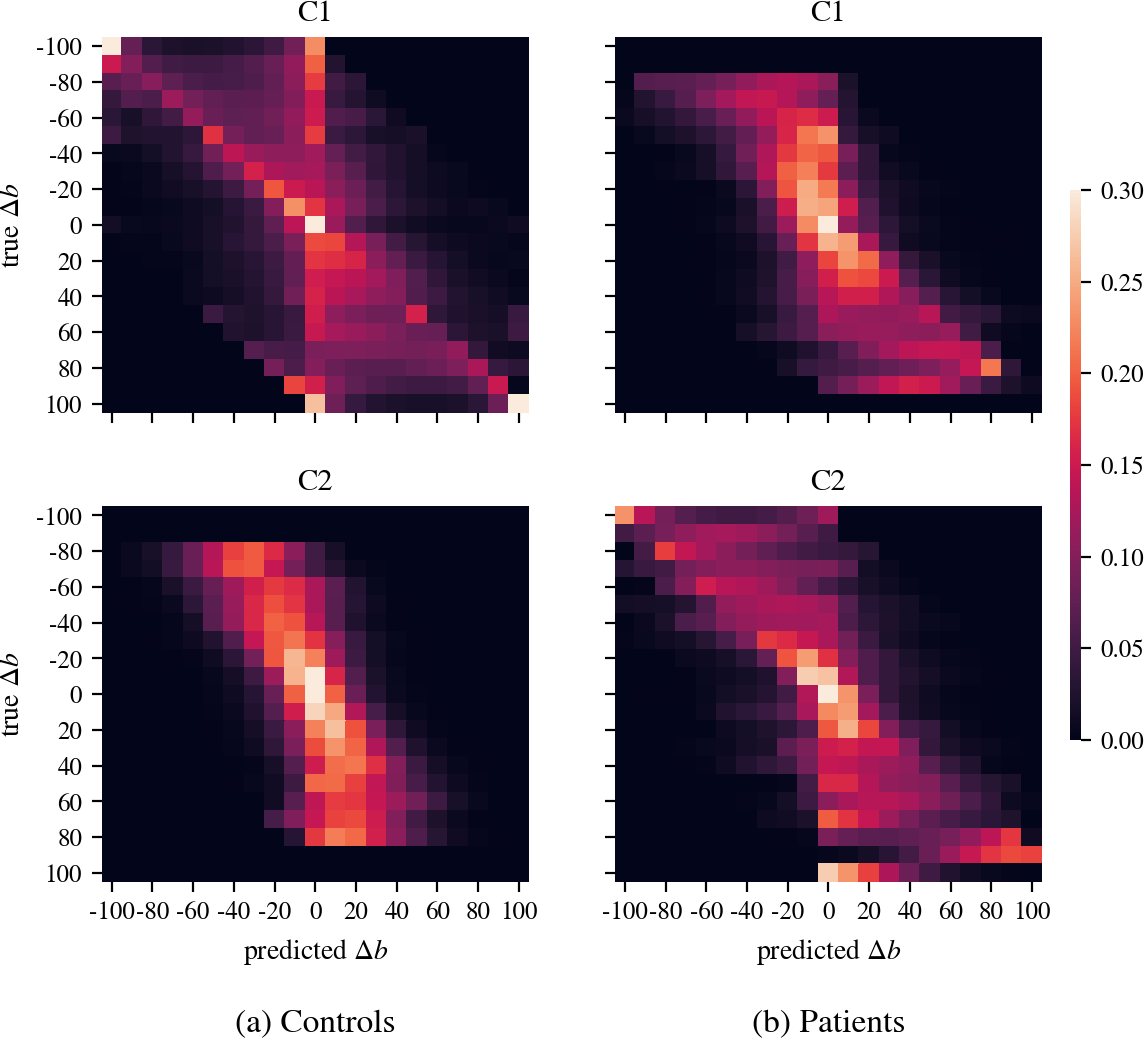

In [13]:
fig, axs = plt.subplots(2,2, figsize=(figwidth,5.5), dpi=200, sharex=True, sharey=True)
bins = np.linspace(0,1,51)
cbar_ax = fig.add_axes([.95, .3, .01, .5])
d_bets = np.arange(-100, 101, 10)

for j, (cluster_data, cluster_all_ps, preds) in enumerate(zip(all_data, results_basic[2], all_preds)):
    
    for cluster in [0,1]:
        data = np.array(cluster_data)[preds==cluster]
        freqs=np.zeros((len(d_bets), 21))
        
        for i, d_bet in enumerate(d_bets):
            
            for subject, ps in zip(data, cluster_all_ps[cluster]):
                freqs[i]  += ps[subject[:-1]['d_bet']==d_bet].sum(0)
            
            if freqs[i].sum()>0:
                freqs[i] /= freqs[i].sum()
        

        im = sns.heatmap(freqs, ax=axs[cluster,j], vmax=.3, cbar=True, rasterized=True, cbar_ax=cbar_ax)
        
        axs[1, j].set_xticklabels(d_bets[::2], rotation=0)
        axs[1, j].set_xlabel('predicted $\Delta b$')
        axs[cluster, 0].set_yticklabels(d_bets[::2], rotation=0)
        axs[cluster, 0].set_ylabel('true $\Delta b$')
        
        axs[cluster, j].set_title('C%d' % (cluster+1))

axs[1,0].text(0.5, -.4, '(a) Controls', ha='center', fontsize=12,transform=axs[1,0].transAxes)
axs[1,1].text(0.5, -.4,'(b) Patients', ha='center', fontsize=12,transform=axs[1,1].transAxes)
plt.tight_layout(rect=[0, 0, .96, 1])
plt.subplots_adjust(hspace=.25, wspace=.2)
plt.savefig('../figures/comp_calibration_plot.pdf')
plt.savefig('../figures/comp_calibration_plot.png')

# Model with weighing past outcomes

In [14]:
opt_params_with_past = ['w_prev',
              'w_rej',
              'w_reg',
              'w_crej',
              'w_creg',
              'w_mu',
              'w_up',
              'w_down',
              'alpha'
]

results_with_past = fit_model(all_data, all_preds, opt_params_with_past)

Cluster: 1, BIC 15923
Cluster: 2, BIC 14800
Cluster: 1, BIC 5310
Cluster: 2, BIC 2576


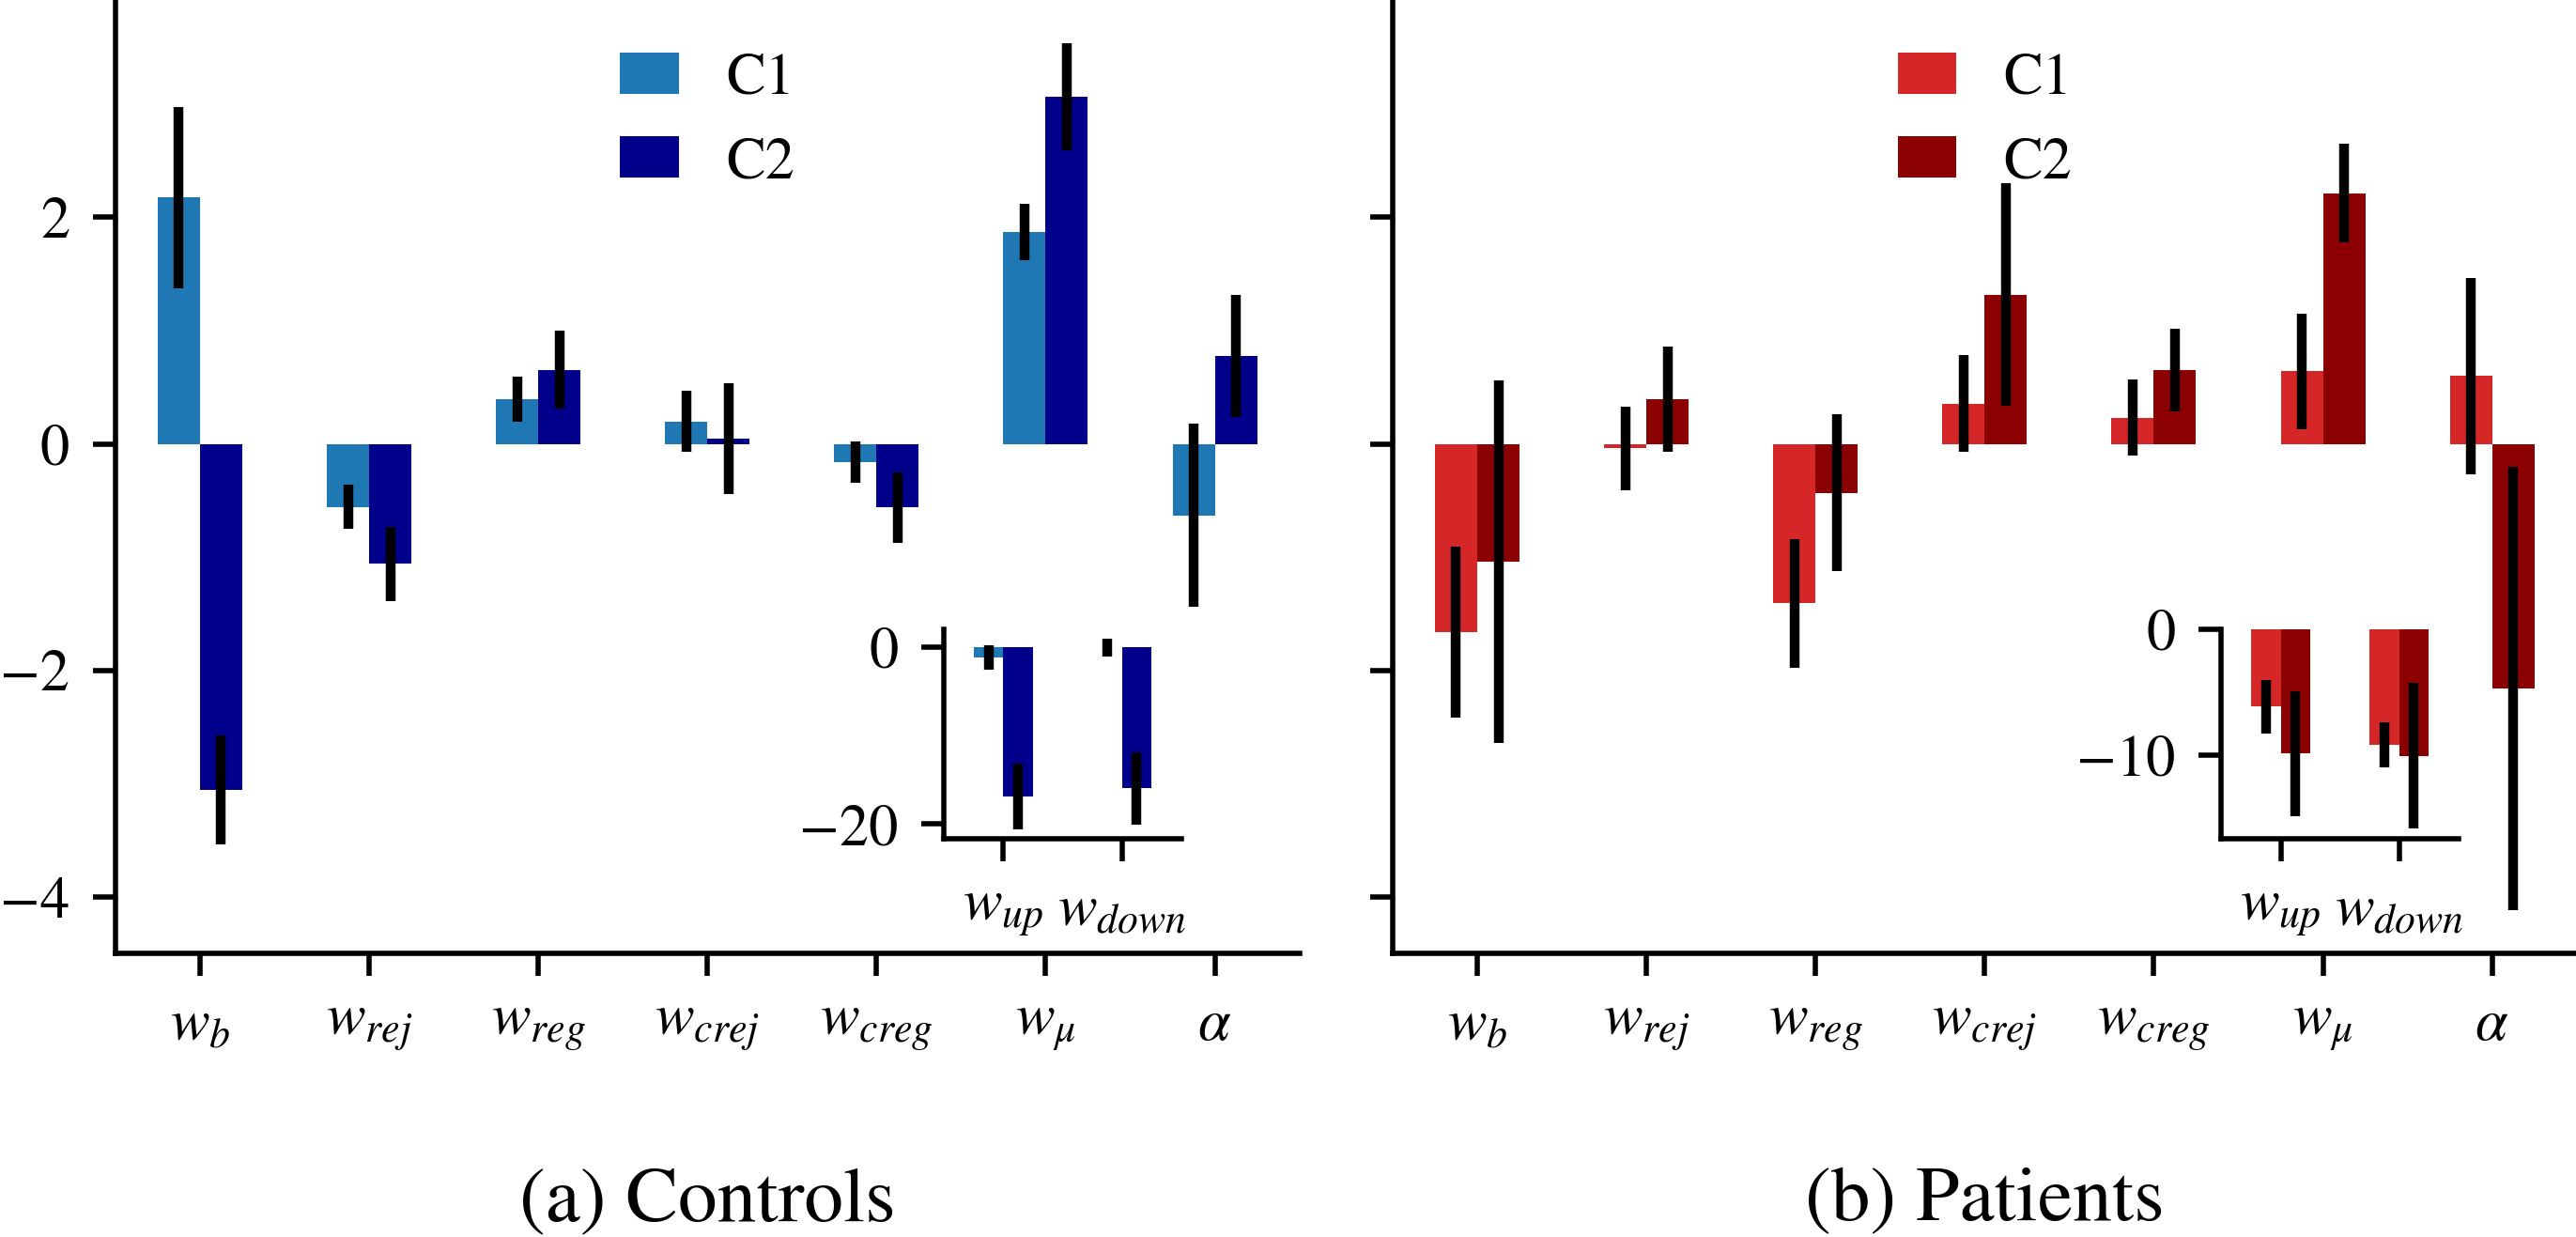

In [24]:
for i, result in enumerate(results_with_past[0]):
    for cluster in [0,1]:
        print('Cluster: %d, BIC %d' % (cluster+1, result[cluster]['bic'].sum()))

fig, ax = plt.subplots(1,2,figsize=(figwidth, 3), dpi=500, sharey=True)

for i, result in enumerate(results_with_past[0]):
    results_cluster1 = result[0].drop(columns=['bic', 'll', 'w_up', 'w_down'])
    results_cluster2 = result[1].drop(columns=['bic', 'll', 'w_up', 'w_down'])
    err = [sem(results_cluster1), sem(results_cluster2)]
    
    pd.DataFrame({'C1': results_cluster1.mean(), 'C2': results_cluster2.mean()}).plot(kind='bar', ax=ax[i], color=colors[i], yerr=err).legend(loc='upper center', frameon=False, handlelength=1)
    ax[i].set_xticklabels(convert_to_labels(results_cluster1.columns), rotation=0)

    ins = ax[i].inset_axes([0.7,0.12,0.2,0.22])
    results_cluster1 = result[0][['w_up', 'w_down']]
    results_cluster2 = result[1][['w_up', 'w_down']]
    err = [sem(results_cluster1), sem(results_cluster2)]
    pd.DataFrame({'C1': results_cluster1.mean(), 'C2': results_cluster2.mean()}).plot(kind='bar', ax=ins, color=colors[i], yerr=err, legend=False)
    ins.set_xticklabels(convert_to_labels(results_cluster1.columns), rotation=0, fontsize=9)

ax[0].text(0.5, -.28, '(a) Controls', ha='center', fontsize=12,transform=ax[0].transAxes)
ax[1].text(0.5, -.28 ,'(b) Patients', ha='center', fontsize=12,transform=ax[1].transAxes)
plt.tight_layout()
plt.savefig('../figures/comp_with_past.pdf')

# Model with state dependency

In [16]:
opt_params_with_states = ['w_prev',
              'w_rej',
              'w_reg',
              'w_crej',
              'w_creg',
              'w_mu',
#               'w_sigma',
              'w_up',
              'w_down',
#               'alpha'
              'a_mu',
              'a_sigma',
              'a_rej',
              'a_crej',
              'a_reg',
              'a_creg',
              'a_up',
              'a_down',
]

results_with_states = fit_model(all_data, all_preds, opt_params_with_states)

Cluster: 1, BIC 15404
Cluster: 2, BIC 14955
Cluster: 1, BIC 5227
Cluster: 2, BIC 2585


<ipython-input-26-8ec41158ccda>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ins.set_yticklabels(ins.get_yticks(), fontsize=7)
<ipython-input-26-8ec41158ccda>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ins.set_yticklabels(ins.get_yticks(), fontsize=7)


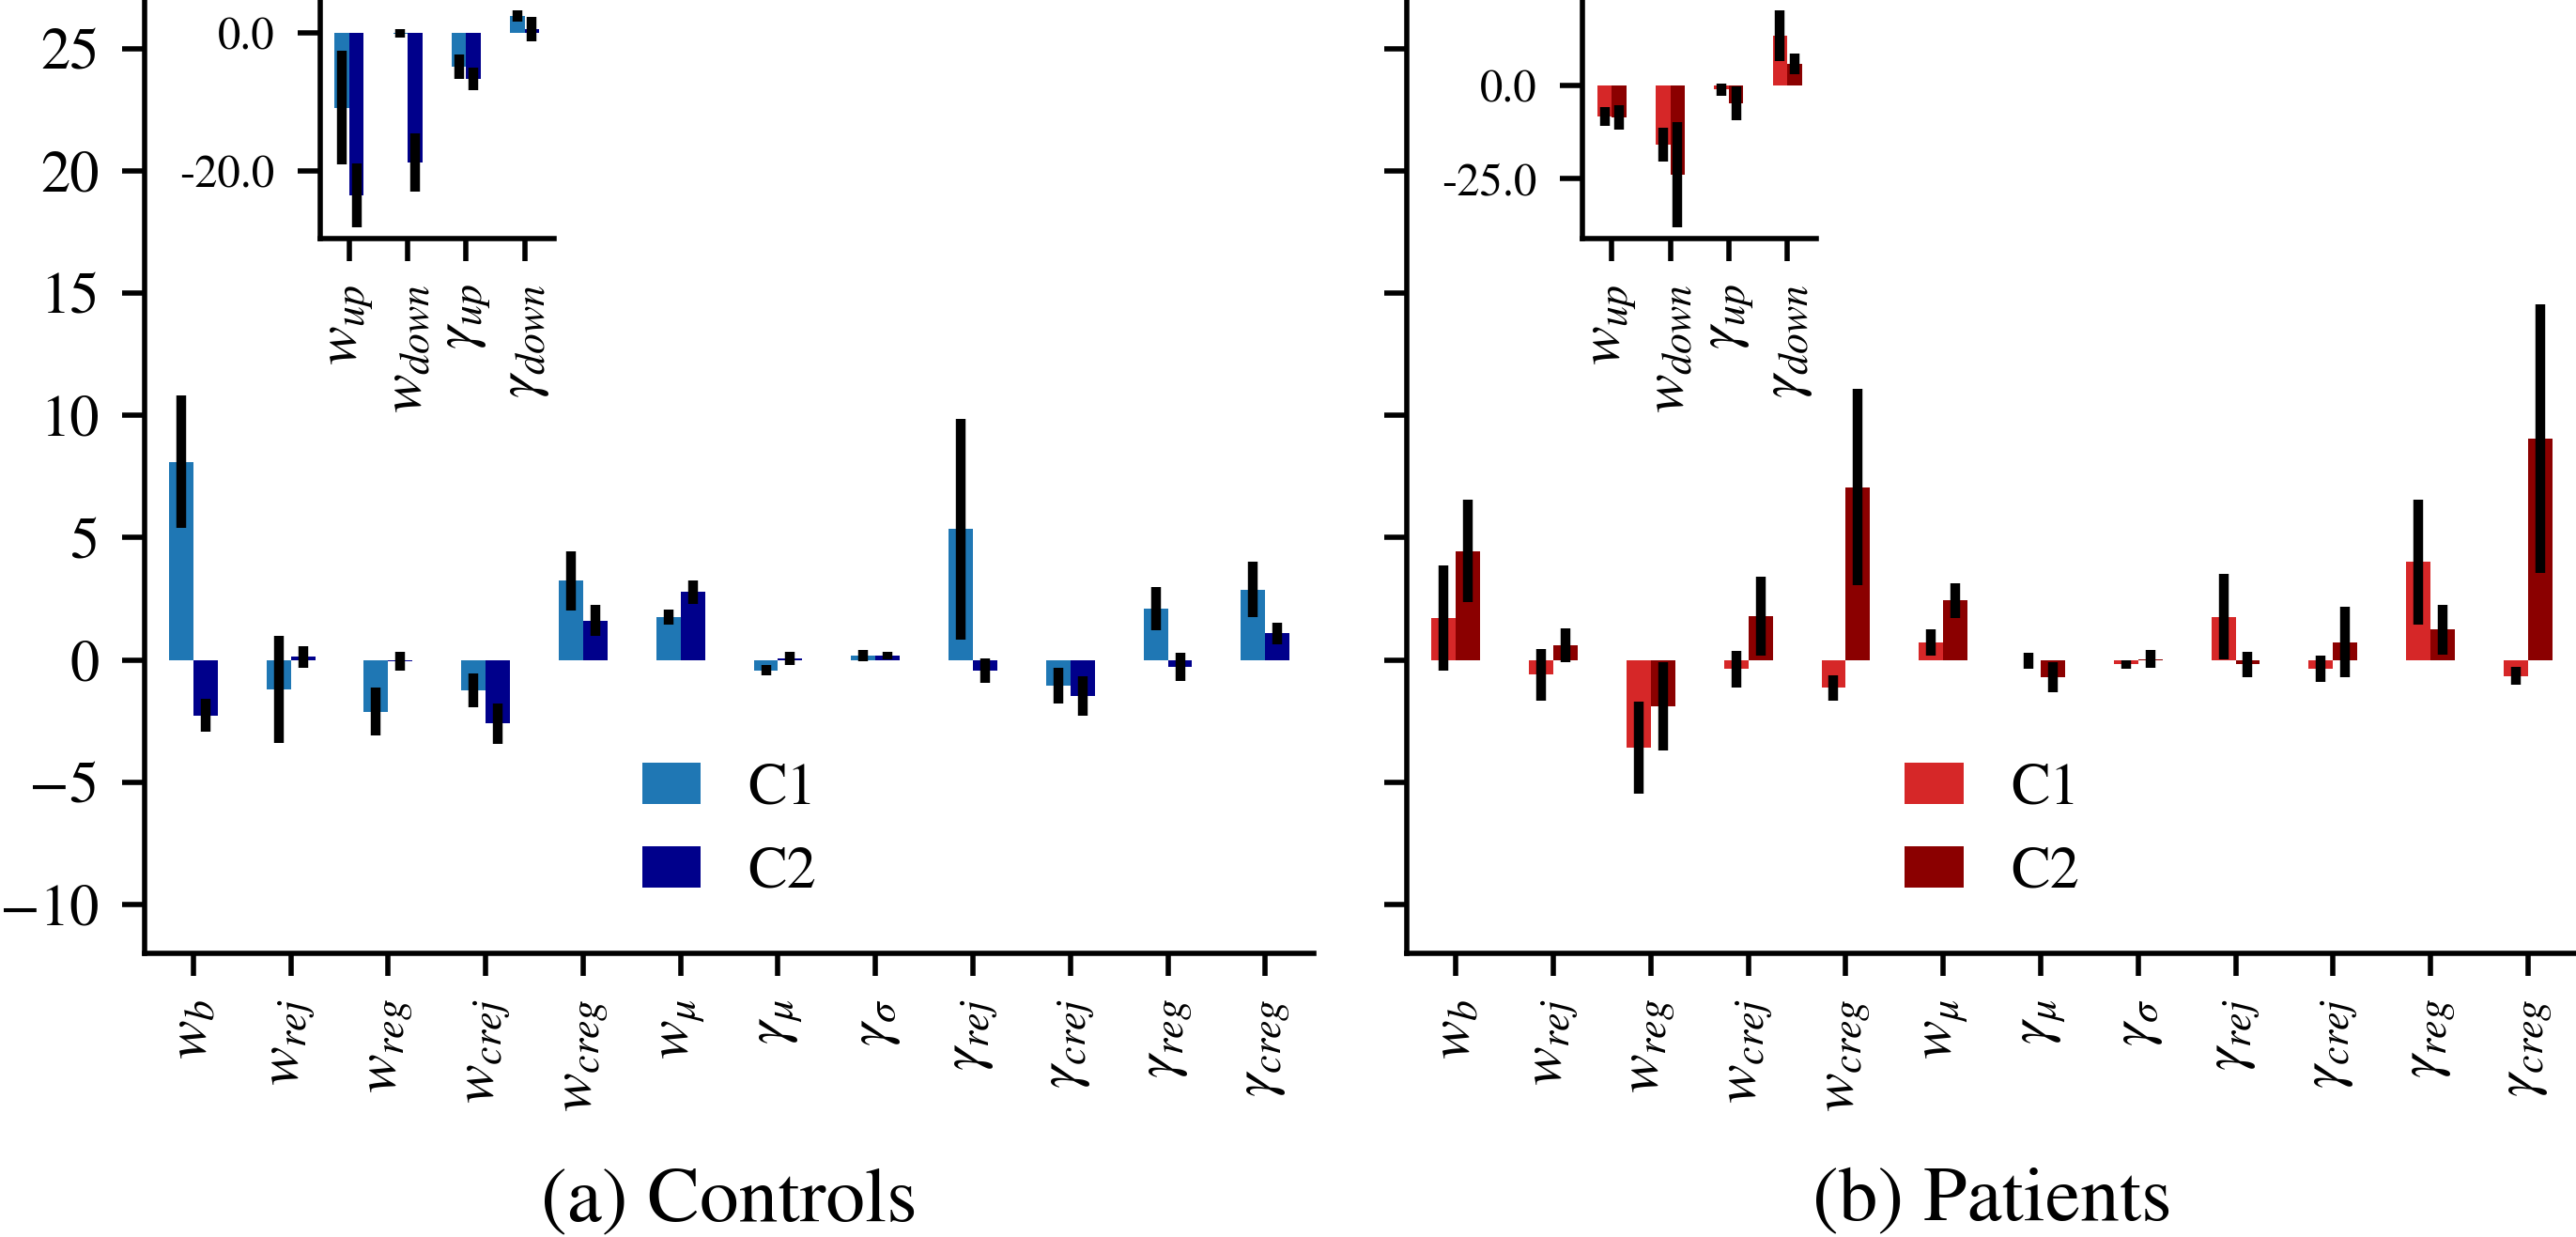

In [26]:
for i, result in enumerate(results_with_states[0]):
    for cluster in [0,1]:
        print('Cluster: %d, BIC %d' % (cluster+1, result[cluster]['bic'].sum()))

fig, ax = plt.subplots(1,2,figsize=(figwidth, 3), dpi=500, sharey=True)

for i, result in enumerate(results_with_states[0]):
    results_cluster1 = result[0].drop(columns=['bic', 'll', 'w_up', 'w_down', 'a_up', 'a_down'])
    results_cluster2 = result[1].drop(columns=['bic', 'll', 'w_up', 'w_down', 'a_up', 'a_down'])
    err = [sem(results_cluster1), sem(results_cluster2)]
    
    pd.DataFrame({'C1': results_cluster1.mean(), 'C2': results_cluster2.mean()}).plot(kind='bar', ax=ax[i], color=colors[i], yerr=err).legend(loc='lower center', frameon=False, handlelength=1)
    ax[i].set_xticklabels(convert_to_labels(results_cluster1.columns), rotation=90)

    ins = ax[i].inset_axes([0.15,0.75,0.2,0.25])
    
    results_cluster1 = result[0][['w_up', 'w_down', 'a_up', 'a_down']]
    results_cluster2 = result[1][['w_up', 'w_down', 'a_up', 'a_down']]
    err = [sem(results_cluster1), sem(results_cluster2)]
    pd.DataFrame({'C1': results_cluster1.mean(), 'C2': results_cluster2.mean()}).plot(kind='bar', ax=ins, color=colors[i], yerr=err, legend=False)
    ins.set_xticklabels(convert_to_labels(results_cluster1.columns), rotation=90, fontsize=9)
    ins.set_yticklabels(ins.get_yticks(), fontsize=7)

plt.ylim(-12,27)
ax[0].text(0.5, -.28, '(a) Controls', ha='center', fontsize=12,transform=ax[0].transAxes)
ax[1].text(0.5, -.28 ,'(b) Patients', ha='center', fontsize=12,transform=ax[1].transAxes)
plt.tight_layout()
plt.savefig('../figures/comp_with_states.pdf')